This notebook contains code for model comparison. Optimal hyperparameters for models are supposed to be already found.

# Imports

In [ ]:
#imports
!pip install scipydirect

import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import preprocessing
from sklearn.preprocessing import normalize

from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

import collections
from collections import Counter
from imblearn.over_sampling import SMOTE


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from IPython import display

from scipydirect import minimize # for DIvided RECTangles (DIRECT) method
import time

     |████████████████████████████████| 51kB 4.7MB/s 
  Created wheel for scipydirect: filename=scipydirect-1.3-cp37-cp37m-linux_x86_64.whl size=119893 sha256=201aad9d5036ecc1328b332fbd9c6adc620fa9b0d03010fc0ccea07c5bea8a47
  Stored in directory: /root/.cache/pip/wheels/b7/de/2b/c5550296e6dac87737c622568c6a10bc87ae76e98b52ff210e
Successfully built scipydirect


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# 1) Describe classes of the following models: AdaFair, SMOTEBoost, ASR

#### 1.1) AdaFair

In [ ]:
#AdaFair
class AdaFairClassifier(AdaBoostClassifier):
    def __init__(self,
                 base_estimator=None, *,
                 n_estimators=50,
                 learning_rate=1,
                 algorithm='SAMME',
                 random_state=42,
                 protected=None,
                 epsilon = 0):

        super().__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators,
            algorithm = algorithm,
            learning_rate=learning_rate,
            random_state=random_state)

        self.protected = np.array(protected)
        self.algorithm = algorithm
        self.epsilon = epsilon
    
    def _boost_discrete(self, iboost, X, y, sample_weight, random_state):
        """Implement a single boost using the SAMME discrete algorithm."""
        estimator = self._make_estimator(random_state=random_state)

        estimator.fit(X, y, sample_weight=sample_weight)

        y_predict = estimator.predict(X)

        if iboost == 0:
            self.classes_ = getattr(estimator, 'classes_', None)
            self.n_classes_ = len(self.classes_)

        # Instances incorrectly classified
        incorrect = y_predict != y

        # Error fraction
        estimator_error = np.mean(
            np.average(incorrect, weights=sample_weight, axis=0))

        # Stop if classification is perfect
        if estimator_error <= 0:
            return sample_weight, 1., 0.

        n_classes = self.n_classes_

        # Stop if the error is at least as bad as random guessing
        if estimator_error >= 1. - (1. / n_classes):
            self.estimators_.pop(-1)
            if len(self.estimators_) == 0:
                print ("BaseClassifier in AdaBoostClassifier ensemble is worse than random, ensemble can not be fit.")
                raise ValueError('BaseClassifier in AdaBoostClassifier '
                                 'ensemble is worse than random, ensemble '
                                 'can not be fit.')
            return None, None, None

        if len(self.protected) != len(y):
          print ("Error: not given or given incorrect list of protected objects")
          return None, None, None

        #Compute fairness-related costs
        #CUMULATIVE prediction 
        
        y_cumulative_pred = list(self.staged_predict(X))[0]

        u = np.array(self.get_fairness_related_costs(y, y_cumulative_pred, self.protected))

        # Boost weight using multi-class AdaBoost SAMME alg
        estimator_weight = self.learning_rate * (
            np.log((1. - estimator_error) / estimator_error) +
            np.log(n_classes - 1.))

        # Only boost the weights if I will fit again
        if not iboost == self.n_estimators - 1:
            # Only boost positive weights

            sample_weight = sample_weight * np.exp(estimator_weight * incorrect * (sample_weight > 0)) * (np.ones(len(u)) + u)

        return sample_weight, estimator_weight, estimator_error

    def get_fairness_related_costs(self, y, y_pred_t, protected):

        y_true_protected, y_pred_protected, y_true_non_protected, y_pred_non_protected = separate_protected_from_non_protected(y, y_pred_t, protected)
        #Rates for non protected group
        tp, tn, fp, fn = tp_tn_fp_fn(y_true_non_protected, y_pred_non_protected)
        FPR_non_protected = fp / (fp + tn)
        FNR_non_protected = fn / (fn + tp)
        #Rates for protected group
        tp, tn, fp, fn = tp_tn_fp_fn(y_true_protected, y_pred_protected)
        FPR_protected = fp / (fp + tn)
        FNR_protected = fn / (fn + tp)
  
        delta_FPR = - FPR_non_protected + FPR_protected 
        delta_FNR = - FNR_non_protected + FNR_protected

        self.delta_FPR = delta_FPR
        self.delta_FNR = delta_FNR
        #Compute fairness related costs
        u = []
        for y_i, y_pred_t__i, protection  in zip(y, y_pred_t, protected):
            if y_i == 1 and y_pred_t__i == 0 and abs(delta_FNR) > self.epsilon and protection == 1 and delta_FNR > 0:
                u.append(abs(delta_FNR))
            elif y_i == 1 and y_pred_t__i == 0 and abs(delta_FNR) > self.epsilon and protection == 0 and delta_FNR < 0:
                u.append(abs(delta_FNR))
            elif y_i == 0 and y_pred_t__i == 1 and abs(delta_FPR) > self.epsilon and protection == 1 and delta_FPR > 0:
                u.append(abs(delta_FPR))
            elif y_i == 0 and y_pred_t__i == 1 and abs(delta_FPR) > self.epsilon and protection == 0 and delta_FPR < 0:
                u.append(abs(delta_FPR))
            else: u.append(0)
        return u

#### 1.2 SMOTEBoost

In [ ]:
#SMOTEBoost

random_state = 42

#4, y - true label
def ada_boost_eps(y, y_pred_t, distribution):
  eps = np.sum((1 - (y == y_pred_t) + (np.logical_not(y) == y_pred_t)) * distribution)
  return eps

#5
def ada_boost_betta(eps):
  betta = eps/(1 - eps)
  return betta

def ada_boost_w(y, y_pred_t):
  w = 0.5 * (1 + (y == y_pred_t) - (np.logical_not(y) == y_pred_t))
  return w

#6
def ada_boost_distribution(distribution, betta, w):
  distribution = distribution * betta ** w  / np.sum(distribution)
  return distribution

def min_target(y):
  minority_target = min(Counter(y), key=Counter(y).get)
  return minority_target

class SMOTEBoost():
    
    def __init__(self,
                 n_samples = 100,
                 k_neighbors = 5,  
                 n_estimators = 50, #n_estimators = T
                 base_classifier = None,
                 random_state = 42,
                 get_eps = ada_boost_eps,
                 get_betta = ada_boost_betta,
                 get_w = ada_boost_w,
                 update_distribution=ada_boost_distribution):
        self.n_samples = n_samples
        self.k_neighbors = k_neighbors
        self.n_estimators = n_estimators
        self.base_classifier = base_classifier
        self.random_state = random_state
        self.get_eps = get_eps
        self.get_betta = get_betta
        self.get_w = get_w
        self.update_distribution = update_distribution
        
    def fit(self, X, y):
        X = np.array(X)
        distribution = np.ones(X.shape[0], dtype=float) / X.shape[0]
        self.classifiers = []
        self.betta = []
        y = np.array(y)
        for i in range(self.n_estimators):
            minority_class = min_target(y)
            X_min = X[np.where(y == minority_class)]

            # create a new classifier
            self.classifiers.append(self.base_classifier())

            # SMOTE
            self.smote = SMOTE(n_samples=self.n_samples,
                               k_neighbors=self.k_neighbors,
                               random_state=self.random_state)
            self.smote.fit(X_min)
            X_syn = self.smote.sample()
            y_syn = np.full(X_syn.shape[0], fill_value=minority_class, dtype=np.int64)

            # Modify distribution
            distribution_syn = np.empty(X_syn.shape[0], dtype=np.float64)
            distribution_syn[:] = 1. / X.shape[0]
            mod_distribution = np.append(distribution, distribution_syn).reshape(1, -1)
            mod_distribution = np.squeeze(normalize(mod_distribution, axis=1, norm='l1'))
            # Concatenate original and synthetic datasets for training a weak learner
            mod_X = np.vstack((X, X_syn))
            mod_y = np.append(y, y_syn) 

            # Train a weak lerner
            self.classifiers[-1].fit(mod_X, mod_y, sample_weight=mod_distribution)

            # Make a prediction for the original dataset
            y_pred_t = self.classifiers[-1].predict(X)
            
            # Compute the pseudo-loss of hypothesis
            eps_t = ada_boost_eps(y, y_pred_t, distribution)
            betta_t = ada_boost_betta(eps_t)
            w_t = ada_boost_w(y, y_pred_t)
            self.betta.append(betta_t)
            
            # Update distribution and normalize
            distribution = ada_boost_distribution(distribution, betta_t, w_t)
          
    def predict(self, X):
        final_predictions_0 = np.zeros(X.shape[0])
        final_predictions_1 = np.zeros(X.shape[0])
        y_pred = np.empty(X.shape[0])
        # get the weighted votes of the classifiers
        for i in range(len(self.betta)):
            h_i = self.classifiers[i].predict(X)
            final_predictions_0 = final_predictions_0 + math.log(1/self.betta[i])*(h_i == 0)
            final_predictions_1 = final_predictions_1 + math.log(1/self.betta[i])*(h_i == 1)
        for i in range(len(final_predictions_0)):
            if final_predictions_0[i] > final_predictions_1[i]:
                y_pred[i] = 0
            else:
                y_pred[i] = 1
        return y_pred


class SMOTE():

    def __init__(self, n_samples, k_neighbors=5, random_state=None):
        self.n_samples = n_samples
        self.k = k_neighbors
        self.random_state = random_state

    def fit(self, X):
        self.X = X
        self.n_features = self.X.shape[1]
        self.neigh = NearestNeighbors(n_neighbors=self.k) #k + 1
        self.neigh.fit(self.X)
        return self

    def sample(self):
        np.random.seed(seed=self.random_state)
        S = np.zeros(shape=(self.n_samples, self.n_features))

        for i in range(self.n_samples):
            j = np.random.randint(0, self.X.shape[0])
            nn = self.neigh.kneighbors(self.X[j].reshape(1, -1),
                                       return_distance=False)[:, 1:]
            nn_index = np.random.choice(nn[0])
            print (self.X[nn_index], self.X[j])
            dif = self.X[nn_index] - self.X[j]
            gap = np.random.random() 
            S[i, :] = self.X[j, :] + gap * dif[:]
        return S

#### 1.3 Adaptive sensitive reweighting

In [ ]:
#Adaptive sensitive reweighting
class ReweightedClassifier:
    def __init__(self, baze_clf, alpha, beta, params = {}):
        """
        Input: 
        baze_clf   - object from sklearn with methods .fit(sample_weight=), .predict(), .predict_proba()
        alpha      - list of alphas for sensitive and non-sensitive objects [alpha, alpha']
        beta       - list of betss for sensitive and non-sensitive objects [beta, beta']
        params     - **kwargs compatible with baze_clf
        
        """
        self.baze_clf = baze_clf 
        self.model = None
        self.alpha = np.array(alpha)
        self.alphas = None
        self.beta = np.array(beta)
        self.betas = None
        self.weights = None
        self.prev_weights = None
        self.params = params
    
    def reweight_dataset(self, length, error, minority_idx):
        """
        This function recalculates values of weights and saves their previous values
        """
        if self.alphas is None or self.betas is None:
            # If alpha_0, alpha_1 or beta_0, beta_1 are not defined,
            # then define alpha_0 and beta_0 to every object from non-sensitive class,
            # and alpha_1 and beta_1 to every object from sensitive class (minority).
            self.alphas = np.ones(length) * self.alpha[0]
            self.betas = np.ones(length) * self.beta[0]
            self.alphas[minority_idx] = self.alpha[1]
            self.betas[minority_idx] = self.beta[1]
        
        # w_i_prev <- w_i for all i in dataset
        self.prev_weights = self.weights.copy()
        
        # w_i = alpha_i * L_{beta_i} (P'(y_pred_i =! y_true_i)) 
        #       + (1 - alpha_i) * L_{beta_i} (-P'(y_pred_i =! y_true_i)),
        # where 
        # L_{beta_i} (x) = exp(beta_i * x)
        self.weights = self.alphas * np.exp(self.betas * error) \
                       + (1 - self.alphas) * np.exp(- self.betas * error)
    
    def pRule(self, prediction, minority_idx):
        """
        This function calculates 
                    | P(y_pred_i = 1 | i in S)       P(y_pred_i = 1 | i not in S) |
        pRule = min { ---------------------------- , ---------------------------- }
                    | P(y_pred_i = 1 | i not in S)   P(y_pred_i = 1 | i in S)     |
        
        S - the group of sensitive objects
        ---------
        Input:
        prediction - labels ({0,1}) of a sample for which pRule is calculated
        minority_idx - indexes of objects from a sensitive group
        """
        # majority indexes = set of all indexes / set of minority indexes,
        # where set of all indexes = all numbers from 0 to size of sample (=len(prediction))
        majority_idx = set(np.linspace(0, len(prediction) - 1, len(prediction), dtype = int)).difference(minority_idx)
        
        # minority = P(y_pred_i = 1 | i in minority)
        # majority = P(y_pred_i = 1 | i in majority)
        minority = prediction[minority_idx].mean()
        majority = prediction[list(majority_idx)].mean()
        
        minority = np.clip(minority, 1e-10, 1 - 1e-10)
        majority = np.clip(majority, 1e-10, 1 - 1e-10)
        
        return min(minority/majority, majority/minority)    
    
    def fit(self, X_train, y_train, X_test, y_test, minority_idx, verbose=True, max_iter=30):
        # Initialize equal weights w_i = 1
        self.weights = np.ones(len(y_train))
        self.prev_weights = np.zeros(len(y_train))
        
        # Lists for saving metrics
        accuracys = []
        pRules = []
        differences = []
        accuracy_plus_prule = []
        
        # Adaptive Sensitive Reweighting
        iteration = 0
        
        while ((self.prev_weights - self.weights) ** 2).mean() > 10**(-6) and iteration < max_iter:
            
            iteration += 1
            # Train classifier on X_train with weights w_i
            self.model = self.baze_clf(**self.params)
            self.model.fit(X_train, y_train, sample_weight = self.weights)
            
            # Use classifier to obtain P`(y_pred_i =! y_pred) (here it is called 'error')
            prediction_proba = self.model.predict_proba(X_train)[:, 1]
            error = (y_train == 1) * (1 - prediction_proba) + (y_train == 0) * prediction_proba 
            
            # Update weights
            self.reweight_dataset(len(y_train), error, minority_idx)
            
            # Get metrics on X_train
            prediction = self.model.predict(X_train)
            accuracys.append(accuracy_score(prediction, y_train))
            pRules.append(self.pRule(prediction, minority_idx))
            accuracy_plus_prule.append(accuracys[-1] + pRules[-1])
            differences.append(((self.prev_weights - self.weights)**2).mean()**0.5)
            
            # Visualize metrics if it's needed
            if verbose:
                display.clear_output(True)
                fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 7))

                metrics = [accuracys, pRules, accuracy_plus_prule, differences]
                metrics_names = ["Accuracy score", "pRule", "Accuracy + pRule", "Mean of weight edits"]
                for name, metric, ax in zip(metrics_names, metrics, axes.flat):
                    ax.plot(metric, label='train')
                    ax.set_title(f'{name}, iteration {iteration}')
                    ax.legend()
                    if name == "Mean of weight edits":
                        ax.set_yscale('log')
                plt.show()
                
        return accuracys, pRules, accuracy_plus_prule
        
        
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    
    def get_metrics_test(self, X_test, y_test, minority_idx_test):
        """
        Obtain pRule and accuracy for trained model
        """
        # Obtain predictions on X_test to calculate metrics
        prediction_test = self.model.predict(X_test)

        # Get metrics on test
        accuracy_test = accuracy_score(prediction_test, y_test)
        pRule_test = self.pRule(prediction_test, minority_idx_test)

        return accuracy_test, pRule_test 

def prep_train_model(X_train, y_train, X_test, y_test, minority_idx):
    
    def train_model(a):
        """
        Function of 4 variables (a[0], a[1], a[2], a[3]) that will be minimized by DIRECT method.
        a[0], a[1] = alpha, alpha'
        a[2], a[3] = beta, beta'
        """
        model = ReweightedClassifier(LogisticRegression, [a[0], a[1]], [a[2], a[3]], params = {"max_iter": 4000})
        _, _, accuracy_plus_prule = model.fit(X_train, y_train, X_test, y_test, minority_idx)

        # We'll maximize [acc + pRule] which we get at the last iteration of Adaptive Sensitive Reweighting
        return - accuracy_plus_prule[-1]
    
    return train_model # return function for optimization

#### 1.4 Some functions used for fitting models, calculating metrics, and data separation

In [ ]:
#This function returns binary list of whether the corresponding feature is protected (1) or not (0)
def get_protected_instances(X, feature, label):
  protected = []
  for i in range(len(X)):
    if X.iloc[i][feature] == label:
      protected.append(1)
    else: protected.append(0)
  return protected

#To calculate TRP and TNR for protected and non-protected groups, first separate them
def separate_protected_from_non_protected(y_true, y_pred, protected):
  y_true_protected = []
  y_pred_protected = []
  y_true_non_protected = []
  y_pred_non_protected = []
  for true_label, pred_label, is_protected in zip(y_true, y_pred, protected):
    if is_protected == 1:
      y_true_protected.append(true_label)
      y_pred_protected.append(pred_label)
    elif is_protected == 0:
      y_true_non_protected.append(true_label)
      y_pred_non_protected.append(pred_label)
    else:
      print("Error: invalid value of in protected array ", is_protected)
      return 0,0,0,0
  return (np.array(y_true_protected), np.array(y_pred_protected), np.array(y_true_non_protected), np.array(y_pred_non_protected))

def tp_tn_fp_fn(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    tp = matrix[1][1]
    tn = matrix[0][0]
    fp = matrix[0][1]
    fn = matrix[1][0]
    return (tp, tn, fp, fn)

#same pRule as in ASR, but used for calculating this metric in others classifiers' predictions
def pRule(prediction, minority_idx):
        """
        This function calculates 
                    | P(y_pred_i = 1 | i in S)       P(y_pred_i = 1 | i not in S) |
        pRule = min { ---------------------------- , ---------------------------- }
                    | P(y_pred_i = 1 | i not in S)   P(y_pred_i = 1 | i in S)     |
        
        S - the group of sensitive objects
        ---------
        Input:
        prediction - labels ({0,1}) of a sample for which pRule is calculated
        minority_idx - indexes of objects from a sensitive group
        """
        # majority indexes = set of all indexes / set of minority indexes,
        # where set of all indexes = all numbers from 0 to size of sample (=len(prediction))
        majority_idx = set(np.linspace(0, len(prediction) - 1, len(prediction), dtype = int)).difference(minority_idx)
        
        # minority = P(y_pred_i = 1 | i in minority)
        # majority = P(y_pred_i = 1 | i in majority)
        minority = prediction[minority_idx].mean()
        majority = prediction[list(majority_idx)].mean()
        
        minority = np.clip(minority, 1e-10, 1 - 1e-10)
        majority = np.clip(majority, 1e-10, 1 - 1e-10)
        
        return min(minority/majority, majority/minority)  

# 2) Download datasets (run one cell for one dataset)

Adult census

In [ ]:
#Adult census
#adult_census_names = ['old_id' ,'age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country']
X_train = pd.read_csv("splits/X_train_preprocessed_adult.csv").drop("Unnamed: 0", axis = 1)#, names = adult_census_names).iloc[1:]
X_test = pd.read_csv("splits/X_test_preprocessed_adult.csv").drop("Unnamed: 0", axis = 1)#, names = adult_census_names).iloc[1:]

y_train = pd.read_csv("splits/y_train_preprocessed_adult.csv")['income']
y_test = pd.read_csv("splits/y_test_preprocessed_adult.csv")['income']
reweight_prediction = "/content/predictions/y_pred_test_adult.csv"

#X_test, X_train = preprocess_adult_census(X_test.drop('old_id', axis = 1)), preprocess_adult_census(X_train.drop('old_id', axis = 1))
#y_test, y_train = adult_label_transform(y_test)['income'], adult_label_transform(y_train)['income']
#Obtain protected group (used in AdaFair)
protected_test = get_protected_instances(X_test, 'gender', 1)
protected_train = get_protected_instances(X_train, 'gender', 1)

# Obtain indexes of sensitive class (for regression algorithm)
minority_idx = X_train.reset_index(drop=True).index.values[X_train["gender"] == 1]
minority_idx_test = X_test.reset_index(drop=True).index.values[X_test["gender"] == 1]

#best hyperparameters for AdaFair
adafair_max_depth = 2
adafair_n_estimators = 20

#result of ASR optimizing
a_1 = [0.01851852, 0.99382716, 1.16666667, 2.94444444]
#print(len(X_train),len(y_train))
#X_train.head()

Bank

In [47]:
X_train = pd.read_csv("splits/X_train_preprocessed_bank.csv").drop("Unnamed: 0", axis = 1)#, names = adult_census_names).iloc[1:]
X_test = pd.read_csv("splits/X_test_preprocessed_bank.csv").drop("Unnamed: 0", axis = 1)#, names = adult_census_names).iloc[1:]

y_train = pd.read_csv("splits/y_train_preprocessed_bank.csv")['y']
y_test = pd.read_csv("splits/y_test_preprocessed_bank.csv")['y']
reweight_prediction = "/content/predictions/y_pred_test_bank.csv"

#X_test, X_train = preprocess_adult_census(X_test.drop('old_id', axis = 1)), preprocess_adult_census(X_train.drop('old_id', axis = 1))
#y_test, y_train = adult_label_transform(y_test)['income'], adult_label_transform(y_train)['income']
#Obtain protected group (used in AdaFair)
protected_test = get_protected_instances(X_test, 'age', 1)
protected_train = get_protected_instances(X_train, 'age', 1)

# Obtain indexes of sensitive class (for regression algorithm)
minority_idx = X_train.reset_index(drop=True).index.values[X_train["age"] == 1]
minority_idx_test = X_test.reset_index(drop=True).index.values[X_test["age"] == 1]

#best hyperparameters for AdaFair
adafair_max_depth = 2
adafair_n_estimators = 9

#result of ASR optimizing
a_1 = [0.87037037, 0.01851852, 2.72222222, 1.57407407] 
#print(len(X_train),len(y_train))
#X_train.head()

Compass

In [54]:
X_train = pd.read_csv("splits/X_train_preprocessed_compas.csv").drop("Unnamed: 0", axis = 1)#, names = adult_census_names).iloc[1:]
X_test = pd.read_csv("splits/X_test_preprocessed_compas.csv").drop("Unnamed: 0", axis = 1)#, names = adult_census_names).iloc[1:]

y_train = pd.read_csv("splits/y_train_preprocessed_compas.csv")['two_year_recid']
y_test = pd.read_csv("splits/y_test_preprocessed_compas.csv")['two_year_recid']
reweight_prediction = "/content/predictions/y_pred_test_compas.csv"

#X_test, X_train = preprocess_adult_census(X_test.drop('old_id', axis = 1)), preprocess_adult_census(X_train.drop('old_id', axis = 1))
#y_test, y_train = adult_label_transform(y_test)['income'], adult_label_transform(y_train)['income']
#Obtain protected group (used in AdaFair)
protected_test = get_protected_instances(X_test, 'race', 0)
protected_train = get_protected_instances(X_train, 'race', 0)

# Obtain indexes of sensitive class (for regression algorithm)
minority_idx = X_train.reset_index(drop=True).index.values[X_train["race"] == 0]
minority_idx_test = X_test.reset_index(drop=True).index.values[X_test["race"] == 0]

#best hyperparameters for AdaFair
adafair_max_depth = 4
adafair_n_estimators = 5

#result of ASR optimizing
a_1 =  [0.0308642, 0.72222222, 0.5, 0.45061728]
#print(len(X_train),len(y_train))
#y_train.head()

KDD Census

In [74]:
#adult_census_names = ['old_id' ,'age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country']
X_train = pd.read_csv("splits/X_train_preprocessed_kdd.csv").drop("Unnamed: 0", axis = 1)#, names = adult_census_names).iloc[1:]
X_test = pd.read_csv("splits/X_test_preprocessed_kdd.csv").drop("Unnamed: 0", axis = 1)#, names = adult_census_names).iloc[1:]

y_train = pd.read_csv("splits/y_train_preprocessed_kdd.csv")['income_50k']
y_test = pd.read_csv("splits/y_test_preprocessed_kdd.csv")['income_50k']
reweight_prediction = "/content/predictions/y_pred_test_kdd.csv"

#X_test, X_train = preprocess_adult_census(X_test.drop('old_id', axis = 1)), preprocess_adult_census(X_train.drop('old_id', axis = 1))
#y_test, y_train = adult_label_transform(y_test)['income'], adult_label_transform(y_train)['income']
#Obtain protected group (used in AdaFair)
protected_test = get_protected_instances(X_test, 'sex', 1)
protected_train = get_protected_instances(X_train, 'sex', 1)

# Obtain indexes of sensitive class (for regression algorithm)
minority_idx = X_train.reset_index(drop=True).index.values[X_train["sex"] == 1]
minority_idx_test = X_test.reset_index(drop=True).index.values[X_test["sex"] == 1]

#best hyperparameters for AdaFair
adafair_max_depth = 5
adafair_n_estimators = 11 

#result of ASR optimizing
a_1 = [0.01851852, 0.99382716, 1.16666667, 2.94444444]
#print(len(X_train),len(y_train))
#X_train.head()

98147 98147


,age,det_ind_code,det_occ_code,sex,capital_gains,capital_losses,stock_dividends,some_numerical_feature,num_emp,own_or_self,vet_benefits,weeks_worked,year,class_worker_ Local government,class_worker_ Never worked,class_worker_ Not in universe,class_worker_ Private,class_worker_ Self-employed-incorporated,class_worker_ Self-employed-not incorporated,class_worker_ State government,class_worker_ Without pay,education_ 11th grade,education_ 12th grade no diploma,education_ 1st 2nd 3rd or 4th grade,education_ 5th or 6th grade,education_ 7th and 8th grade,education_ 9th grade,education_ Associates degree-academic program,education_ Associates degree-occup /vocational,education_ Bachelors degree(BA AB BS),education_ Children,education_ Doctorate degree(PhD EdD),education_ High school graduate,education_ Less than 1st grade,education_ Masters degree(MA MS MEng MEd MSW MBA),education_ Prof school degree (MD DDS DVM LLB JD),education_ Some college but no degree,hs_college_ High school,hs_college_ Not in universe,marital_stat_ Married-A F spouse present,...,country_self_ England,country_self_ France,country_self_ Germany,country_self_ Greece,country_self_ Guatemala,country_self_ Haiti,country_self_ Holand-Netherlands,country_self_ Honduras,country_self_ Hong Kong,country_self_ Hungary,country_self_ India,country_self_ Iran,country_self_ Ireland,country_self_ Italy,country_self_ Jamaica,country_self_ Japan,country_self_ Laos,country_self_ Mexico,country_self_ Nicaragua,country_self_ Outlying-U S (Guam USVI etc),country_self_ Panama,country_self_ Peru,country_self_ Philippines,country_self_ Poland,country_self_ Portugal,country_self_ Puerto-Rico,country_self_ Scotland,country_self_ South Korea,country_self_ Taiwan,country_self_ Thailand,country_self_ Trinadad&Tobago,country_self_ United-States,country_self_ Vietnam,country_self_ Yugoslavia,citizenship_ Foreign born- U S citizen by naturalization,citizenship_ Native- Born abroad of American Parent(s),citizenship_ Native- Born in Puerto Rico or U S Outlying,citizenship_ Native- Born in the United States,vet_question_ Not in universe,vet_question_ Yes
0,0.801615,1.666326,0.261086,1,0.0,0.0,0.099640,0.264331,3.01795,0.0000,1.300236,2.207703,1.005298,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
1,0.458066,2.563579,1.653544,1,0.0,0.0,0.000000,0.562432,0.00000,0.0000,1.300236,0.000000,0.994716,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
2,1.202423,2.371310,2.262745,1,0.0,0.0,0.000000,0.911667,3.01795,0.0000,1.300236,2.207703,0.994716,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
3,1.087907,2.371310,0.261086,0,0.0,0.0,0.000000,0.550690,3.01795,0.0000,1.300236,2.207703,1.005298,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
4,1.087907,1.602237,3.046003,0,0.0,0.0,2.381399,0.885154,3.01795,11.2168,1.300236,2.207703,0.994716,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0


# 3) Create models, train classifiers

In [75]:
#Regression
# Create model with obtained hyperparameters alpha, alpha', beta, beta'
model_reweighted_classifier = ReweightedClassifier(LogisticRegression, [a_1[0], a_1[1]], [a_1[2], a_1[3]], params = {"max_iter": 4})

# Train model on X_train 
model_reweighted_classifier.fit(X_train, y_train, X_test, y_test, minority_idx, verbose=False)

# Calculate metrics (pRule, accuracy) on X_test
accuracy_test, pRule_test = model_reweighted_classifier.get_metrics_test(X_test, y_test, minority_idx_test)


#print('ASR+CULEP for X_test')
#print(f"prule = {pRule_test:.6}, accuracy = {accuracy_test:.6}")
#print(f"prule + accuracy = {(pRule_test + accuracy_test):.6}")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [76]:
#SMOTEBOOST
max_depth = 2
n_samples = 100
k_neighbors = 5
n_estimators = 5 # T
random_state = 42

get_base_clf = lambda: DecisionTreeClassifier(max_depth = max_depth)
smoteboost1 = SMOTEBoost(n_samples = n_samples,
                         k_neighbors = k_neighbors,
                         n_estimators = n_estimators,
                         base_classifier = get_base_clf,
                         random_state = random_state)
smoteboost1.fit(X_train, y_train)
#smote_boost = smoteboost1.predict(X_test)

Выходные данные были обрезаны до нескольких последних строк (5000).
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  1.          0.        ]
[1.34556873 2.75584724 0.17405731 0.         0.         0.
 0.         0.21544598 2.0119666  0.         1.30023581 2.20770341
 0.99471607 1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.       

In [77]:
#AdaFair

#Tolerance to unfairness
epsilon = 0


get_base_clf = lambda: DecisionTreeClassifier(max_depth=adafair_max_depth)

ada_fair = AdaFairClassifier(DecisionTreeClassifier(max_depth=adafair_max_depth),
                                       algorithm="SAMME",
                                       n_estimators=adafair_n_estimators,
                                       protected = protected_train,
                                       epsilon = epsilon)

ada_fair.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:758: RuntimeWarning: invalid value encountered in true_divide
  yield (tmp_pred / norm).sum(axis=1)


AdaFairClassifier(algorithm='SAMME',
                  base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=5,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                         

In [78]:
#Adaboost


ada_boost_sklearn = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
                                       algorithm="SAMME",
                                       n_estimators=n_estimators)

ada_boost_sklearn.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

# 4) Compute and plot metrics

#### 4.1 Compute

In [79]:
names = ['ada_fair','ada_boost_sklearn', 'smoteboost', "reweighted_classifier"]
classifiers = [ada_fair, ada_boost_sklearn, smoteboost1, model_reweighted_classifier]

accuracy = {}
bal_accuracy = {}
TPR = {}
TNR = {}
eq_odds = {}
p_rule = {}
#DELETA
#y_test = y_test[:][1]

for i, clf in enumerate(classifiers):
    print(names[i])
    prediction = clf.predict(X_test)
    if i == 3:
      
      prediction = np.array(pd.read_csv(reweight_prediction, names = ['idx', 'pred'])['pred'][1:])
      print((prediction), (y_test))
      print(len(prediction), len(y_test))

    accuracy[names[i]] = (prediction == y_test).sum() * 1. / len(y_test)
    bal_accuracy[names[i]] = balanced_accuracy_score(y_test, prediction)
    print('accuracy {}: {}'.format(names[i], (prediction == y_test).sum() * 1. / len(y_test))) 
    print('balanced accuracy {}: {}'.format(names[i], balanced_accuracy_score(y_test, prediction))) 
    
    y_true_protected, y_pred_protected, y_true_non_protected, y_pred_non_protected = separate_protected_from_non_protected(y_test, prediction, protected_test)
    
    #TPR for protected group
    tp, tn, fp, fn = tp_tn_fp_fn(y_true_protected, y_pred_protected)
    TPR_protected = tp / (tp + fn)
    TNR_protected = tn / (tn + fp)
    FPR_protected = fp / (fp + tn)
    FNR_protected = fn / (fn + tp)
    print('TPR protected {}: {}'.format(names[i], TPR_protected))
    print('TNR protected {}: {}'.format(names[i], TNR_protected)) 

    TPR[names[i] + ' protected'] = TPR_protected
    TNR[names[i] + ' protected'] = TNR_protected

    #TPR for non protected group
    tp, tn, fp, fn = tp_tn_fp_fn(y_true_non_protected, y_pred_non_protected)
    TPR_non_protected = tp / (tp + fn)
    TNR_non_protected = tn / (tn + fp)
    FPR_non_protected = fp / (fp + tn)
    FNR_non_protected = fn / (fn + tp)
    print('TPR non protected {}: {}'.format(names[i], TPR_non_protected))
    print('TNR non protected {}: {}'.format(names[i], TNR_non_protected))

    delta_FPR = -FPR_non_protected + FPR_protected
    delta_FNR = -FNR_non_protected + FNR_protected
    eq_odds[names[i]] = abs(delta_FPR) + abs(delta_FNR)

    TPR[names[i] + ' non protected'] = TPR_non_protected
    TNR[names[i] + ' non protected'] = TNR_non_protected

    p_rule[names[i]] = pRule(prediction, minority_idx_test)
    print('pRule {}: {}'.format(names[i],p_rule[names[i]]))
    

ada_fair
accuracy ada_fair: 0.9228809846454807
balanced accuracy ada_fair: 0.7176952582693732
TPR protected ada_fair: 0.6626686656671664
TNR protected ada_fair: 0.9330514588008977
TPR non protected ada_fair: 0.4335117332235488
TNR non protected ada_fair: 0.9756010558607405
pRule ada_fair: 0.8097128558491885
ada_boost_sklearn
accuracy ada_boost_sklearn: 0.946417109030332
balanced accuracy ada_boost_sklearn: 0.6529104164181531
TPR protected ada_boost_sklearn: 0.08320839580209895
TNR protected ada_boost_sklearn: 0.9992385379929465
TPR non protected ada_boost_sklearn: 0.3812268423219432
TNR non protected ada_boost_sklearn: 0.976409597869254
pRule ada_boost_sklearn: 0.047964583961589244
smoteboost
accuracy smoteboost: 0.9368192609045616
balanced accuracy smoteboost: 0.5606524639130167
TPR protected smoteboost: 0.13793103448275862
TNR protected smoteboost: 0.984550336646361
TPR non protected smoteboost: 0.12803622890078223
TNR non protected smoteboost: 0.9989536515183943
pRule smoteboost: 0.

#### 4.2 Plot

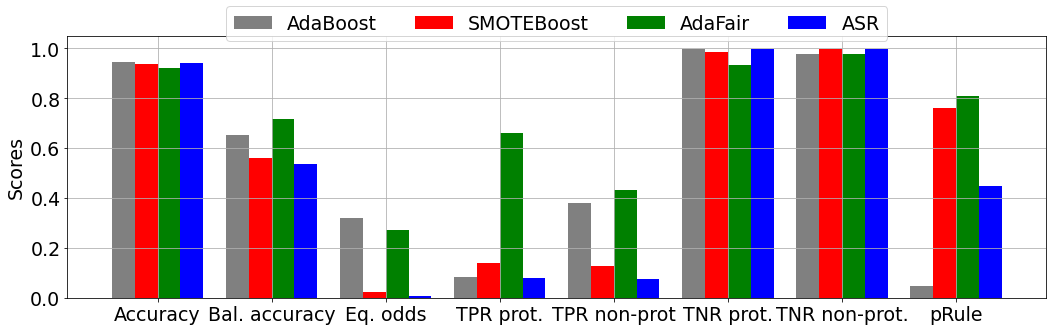

In [80]:
labels = ['Accuracy', 'Bal. accuracy', 'Eq. odds','TPR prot.', 'TPR non-prot', 'TNR prot.', 'TNR non-prot.', 'pRule']
adaFair_metrics = [accuracy['ada_fair'], bal_accuracy['ada_fair'], eq_odds['ada_fair'], TPR['ada_fair protected'], TPR['ada_fair non protected'], TNR['ada_fair protected'], TNR['ada_fair non protected'], p_rule['ada_fair']]
adaBoost_metrics = [accuracy['ada_boost_sklearn'], bal_accuracy['ada_boost_sklearn'], eq_odds['ada_boost_sklearn'], TPR['ada_boost_sklearn protected'], TPR['ada_boost_sklearn non protected'], TNR['ada_boost_sklearn protected'], TNR['ada_boost_sklearn non protected'], p_rule['ada_boost_sklearn']]
SMOTEBoost_metrics = [accuracy['smoteboost'], bal_accuracy['smoteboost'], eq_odds['smoteboost'], TPR['smoteboost protected'], TPR['smoteboost non protected'], TNR['smoteboost protected'], TNR['smoteboost non protected'], p_rule['smoteboost']]
reweighted_class_metrics = [accuracy['reweighted_classifier'], bal_accuracy['reweighted_classifier'], eq_odds['reweighted_classifier'], TPR['reweighted_classifier protected'], TPR['reweighted_classifier non protected'], TNR['reweighted_classifier protected'], TNR['reweighted_classifier non protected'],p_rule['reweighted_classifier']]

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 19}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize = [15, 5])
rects1 = ax.bar(x - 1.5*width, adaBoost_metrics, width, label='AdaBoost', color='gray')
rects2 = ax.bar(x - width/2 , SMOTEBoost_metrics, width, label='SMOTEBoost', color='red')
rects3 = ax.bar(x + width/2, adaFair_metrics, width, label='AdaFair', color='green')
rects4 = ax.bar(x + 1.5*width, reweighted_class_metrics, width, label='ASR', color='blue')

ax.set_ylabel('Scores')
#ax.set_title('Scores by algoritms')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc=9,  ncol = 4, bbox_to_anchor=(0.5, 1.15))
ax.grid()

fig.tight_layout()

plt.show()